In [ ]:
!pip install --upgrade transformers
!pip install sentencepiece
!pip install accelerate -U
!pip install datasets

In [1]:
import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset, Dataset
from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
import torch.nn.functional as F
from torch import nn, optim
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from torch.utils.tensorboard import SummaryWriter

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')


stop_words = stopwords.words('english')
prt = nltk.stem.PorterStemmer()

In [3]:
def preprocess(document_path):
    with open(document_path, 'r', encoding='utf-8') as file:
        document = file.read()

    tokens = nltk.word_tokenize(document)
    tokens_pun_lower = [i.lower() for i in tokens if i.isalnum()]
    tokens_stop = [i for i in tokens_pun_lower if i not in stop_words]
    terms = [prt.stem(i) for i in tokens_stop]

    return " ".join(terms)

In [4]:
Data = []

for dirname, _, filenames in os.walk("/content/drive/MyDrive/archive"):
    for filename in filenames:
        doc_class = filename.split('_')[0].lower()
        doc_titles = filename
        documents = preprocess(os.path.join(dirname, filename))
        Data.append([doc_titles, documents, doc_class])


df = pd.DataFrame(Data, columns=['Title', 'Document', 'Class'])

In [5]:
print(df.shape)
df

(1000, 3)


,Title,Document,Class
0,business_88.txt,saudi ministri employ women women employ saudi...,business
1,business_80.txt,continent run share continent airlin tumbl fir...,business
2,business_66.txt,disast claim insur sought calm fear face huge ...,business
3,business_64.txt,jarvi sell tube stake spain share engin group ...,business
4,business_65.txt,batter dollar hit anoth low dollar fallen new ...,business
...,...,...,...
995,space_92.txt,today new york time wrote pact negoti us russi...,space
996,space_93.txt,articl vnci2b7w165w victor victor lake write a...,space
997,space_95.txt,articl shafer mari shafer write dryden flew fi...,space
998,space_98.txt,articl 1psfan pj0 prb pat write articl 6apr199...,space


In [6]:
df['Class'] = pd.factorize(df['Class'])[0]

df = df.drop("Title", axis=1)

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)


In [7]:
class CustomRobertaDataset(Dataset):
    def __init__(self, dataframe, max_length=256):
        self.data = dataframe
        self.tokenizer = RobertaTokenizer.from_pretrained('roberta-base', max_length=256)
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = str(self.data.iloc[index]['Document'])
        label = int(self.data.iloc[index]['Class'])

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': torch.tensor(label, dtype=torch.long)
        }

def prepare_roberta_data(df, batch_size=8, max_length=256):
    dataset = CustomRobertaDataset(df, max_length=max_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)
    return dataloader


In [ ]:
class CustomRobertaClassifier(nn.Module):
    def __init__(self, num_labels=10, pretrained_model_name="roberta-base"):

        super(CustomRobertaClassifier, self).__init__()
        self.roberta = RobertaModel.from_pretrained(pretrained_model_name)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.roberta.config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids, attention_mask=attention_mask)
        pooled_output = outputs['pooler_output']
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits


custom_roberta_classifier = CustomRobertaClassifier(num_labels=10, pretrained_model_name="roberta-base")

100%|██████████| 88/88 [00:33<00:00,  2.65it/s]


Epoch 1/10, Loss: 0.541366389698603


100%|██████████| 88/88 [00:35<00:00,  2.47it/s]


Epoch 2/10, Loss: 0.26374409889633005


100%|██████████| 88/88 [00:35<00:00,  2.48it/s]


Epoch 3/10, Loss: 0.26287095299498603


100%|██████████| 88/88 [00:34<00:00,  2.52it/s]


Epoch 4/10, Loss: 0.26032017780975863


100%|██████████| 88/88 [00:34<00:00,  2.52it/s]


Epoch 5/10, Loss: 0.25847202911973


100%|██████████| 88/88 [00:35<00:00,  2.49it/s]


Epoch 6/10, Loss: 0.2621665251525966


100%|██████████| 88/88 [00:34<00:00,  2.53it/s]


Epoch 7/10, Loss: 0.260114364664663


100%|██████████| 88/88 [00:35<00:00,  2.50it/s]


Epoch 8/10, Loss: 0.26225621795112436


100%|██████████| 88/88 [00:34<00:00,  2.53it/s]


Epoch 9/10, Loss: 0.26067963310263376


100%|██████████| 88/88 [00:34<00:00,  2.52it/s]


Epoch 10/10, Loss: 0.2548286354338581


100%|██████████| 38/38 [00:05<00:00,  7.25it/s]


Validation Loss: 0.2688411393840062, Accuracy: 0.9566666666666667, Top-5 Accuracy: 1.0


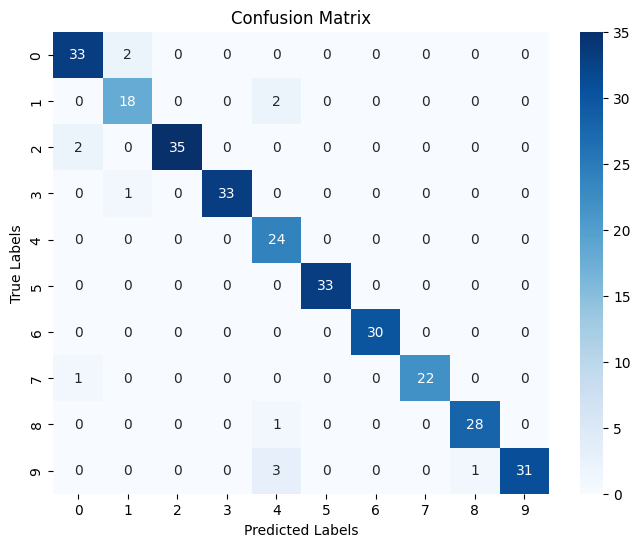

In [34]:
import torch
import torch.nn as nn
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
custom_roberta_classifier.to(device)

train_dataloader = prepare_roberta_data(train_df)
val_dataloader = prepare_roberta_data(val_df)

optimizer = AdamW(custom_roberta_classifier.parameters(), lr=2e-5, no_deprecation_warning=True)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_dataloader)
)

criterion = nn.CrossEntropyLoss()

epochs = 10
writer = SummaryWriter()

def train():
    global writer
    for epoch in range(epochs):
        custom_roberta_classifier.train()
        total_loss = 0.0
        progress_bar = tqdm(train_dataloader, total=len(train_dataloader))

        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()

            outputs = custom_roberta_classifier(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(custom_roberta_classifier.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

        avg_loss = total_loss / len(train_dataloader)
        writer.add_scalar('Train/Loss', avg_loss, epoch + 1)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss}")

    evaluate()

def evaluate():
    global writer
    custom_roberta_classifier.eval()
    total_loss = 0.0
    correct_predictions = 0
    top5_correct_predictions = 0
    total_samples = 0
    all_predicted_labels = []
    all_true_labels = []

    with torch.no_grad():
        progress_bar = tqdm(val_dataloader, total=len(val_dataloader))

        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = custom_roberta_classifier(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted_labels = torch.max(outputs, 1)
            correct_predictions += (predicted_labels == labels).sum().item()


            _, top5_predictions = torch.topk(outputs, 5, dim=1)
            top5_correct_predictions += torch.sum(top5_predictions == labels.view(-1, 1)).item()

            total_samples += labels.size(0)

            all_predicted_labels.extend(predicted_labels.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(val_dataloader)
    accuracy = correct_predictions / total_samples
    top5_accuracy = top5_correct_predictions / total_samples

    writer.add_scalar('Validation/Loss', avg_loss)
    writer.add_scalar('Validation/Accuracy', accuracy)
    writer.add_scalar('Validation/Top5_Accuracy', top5_accuracy)

    print(f"Validation Loss: {avg_loss}, Accuracy: {accuracy}, Top-5 Accuracy: {top5_accuracy}")

    confusion_mat = confusion_matrix(all_true_labels, all_predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


writer.close()

train()


In [35]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', max_length=256)


In [69]:
sentence = """"American Express experienced a notable surge in its shares, climbing over 8% on Tuesday. The boost followed the company's announcement of its decision to spin off
               its less lucrative financial advisory subsidiary. The US credit card and travel services giant, aiming to enhance its profitability, disclosed plans to part ways
               with American Express Financial Advisors (AEFA). With more than 12,000 advisers catering to 2.5 million customers, AEFA has struggled to generate satisfactory profits
               over the years, occasionally facing losses."""

In [70]:
def preprocess(document):

    tokens = nltk.word_tokenize(document)
    tokens_pun_lower = [i.lower() for i in tokens if i.isalnum()]
    tokens_stop = [i for i in tokens_pun_lower if i not in stop_words]
    terms = [prt.stem(i) for i in tokens_stop]

    return " ".join(terms)

text = preprocess(sentence)

In [73]:
encoded_input = tokenizer(text, return_tensors='pt').to(device)

with torch.no_grad():
    custom_roberta_classifier.eval()

    logits = custom_roberta_classifier(**encoded_input)

    probabilities = torch.nn.functional.softmax(logits, dim=1)

    top5_probabilities, top5_labels = torch.topk(probabilities, k=5, dim=1)

top5_probabilities = top5_probabilities.squeeze().tolist()
top5_labels = top5_labels.squeeze().tolist()

print(top5_probabilities,top5_labels)

[0.8304688930511475, 0.04145566374063492, 0.030104689300060272, 0.025722691789269447, 0.016292016953229904] [0, 1, 9, 8, 2]
